In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [60]:
train_data = pd.read_csv("counterfeit_train.csv")
test_data = pd.read_csv("counterfeit_test.csv")

In [61]:
train_data.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402


In [62]:
def combine_columns(row):
    return f"{row['DistArea_ID']}_{row['Area_City_Type']}_{row['Area_Type']}_{row['Area_dist_level']}"

train_data['Area_rep'] = train_data.apply(combine_columns, axis=1)

# train_data['Active_Since']=1/(train_data['Active_Since']-1982)

train_data = train_data.drop(columns=['DistArea_ID','Area_Type','Area_City_Type','Area_dist_level','Medicine_ID','Active_Since'])

categorical_column = ['Medicine_Type','Area_rep','SidEffect_Level']

for i in categorical_column:
        freqs = train_data[i].value_counts()
        k = freqs.index[freqs>20][:-1]

        for cat in k:
            name = f'{i}_{cat}'
            train_data[name] = (train_data[i]==cat).astype(int)
        
        del train_data[i]


numerical_columns = ['Counterfeit_Weight','Medicine_MRP','Availability_rating']
for col in numerical_columns:
    med = train_data[col].mean()
    train_data[col] = train_data[col].fillna(med)


train_y = train_data['Counterfeit_Sales']
train_x = train_data.drop(columns=['Counterfeit_Sales'])


In [44]:
def report(results,ntop=3):
    for i in range(1,ntop+1):
        candidates = np.flatnonzero(results['rank_test_score']==i)
        for candidate in candidates:
            print(f"Model with rank {i}")
            print(f"Mean Validation Score : {results['mean_test_score'][candidate]}, std:{results['std_test_score'][candidate]}")
            print('Parameters: {0}'.format(results['params'][candidate]))
            print("")

In [46]:
# Linear Regression

ln = LinearRegression()
cv_mae = -cross_val_score(ln,train_x,train_y,cv=10,scoring='neg_mean_absolute_error')
cv_mae.mean()

828.5335933941722

In [30]:
# Lasso
lambdas=np.linspace(1,3,30)
params={'alpha':lambdas}
model = Lasso(fit_intercept=True)
grid_search = GridSearchCV(model,
                           param_grid=params,
                           cv=10,
                           scoring='neg_mean_absolute_error',
                           verbose=20,
                           n_jobs=-1)
grid_search.fit(train_x,train_y)

grid_search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


Lasso(alpha=1.7586206896551724)

In [47]:
report(grid_search.cv_results_,5)

Model with rank 1
Mean Validation Score : -828.1800074959883, std:23.47223261937978
Parameters: {'alpha': 3.888888888888889}

Model with rank 2
Mean Validation Score : -828.1811178570313, std:23.520991135298743
Parameters: {'alpha': 3.6666666666666665}

Model with rank 3
Mean Validation Score : -828.1814779661645, std:23.426575838621723
Parameters: {'alpha': 4.111111111111111}

Model with rank 4
Mean Validation Score : -828.1836103609976, std:23.57203258141879
Parameters: {'alpha': 3.4444444444444446}

Model with rank 5
Mean Validation Score : -828.1849545203837, std:23.383367510226154
Parameters: {'alpha': 4.333333333333333}



In [48]:
# Ridge
lambdas=np.linspace(3,5,10)
params={'alpha':lambdas}
model = Ridge(fit_intercept=True)
grid_search = GridSearchCV(model,
                           param_grid=params,
                           cv=10,
                           scoring='neg_mean_absolute_error',
                           verbose=20,
                           n_jobs=-1)
grid_search.fit(train_x,train_y)
grid_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ridge(alpha=3.888888888888889)

In [49]:
report(grid_search.cv_results_,5)

Model with rank 1
Mean Validation Score : -827.8841133240843, std:23.580994436847096
Parameters: {'alpha': 3.888888888888889}

Model with rank 2
Mean Validation Score : -827.8849029211982, std:23.629262036001222
Parameters: {'alpha': 3.6666666666666665}

Model with rank 3
Mean Validation Score : -827.8850368055788, std:23.536092314663655
Parameters: {'alpha': 4.111111111111111}

Model with rank 4
Mean Validation Score : -827.8864681111193, std:23.67958504119817
Parameters: {'alpha': 3.4444444444444446}

Model with rank 5
Mean Validation Score : -827.8883609453217, std:23.49337896287071
Parameters: {'alpha': 4.333333333333333}



In [50]:
# XGBoost
gbm_params = {
    'n_estimators':[100,150,200,250,300],
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
    'max_depth':[1,2,3,4,5,6],
    'subsample':[0.5,0.8,1],
    'max_features':[5,10,15,20,25,30,40]
}

gbm=GradientBoostingRegressor()

random_search = RandomizedSearchCV(gbm,
scoring='neg_mean_absolute_error',
param_distributions=gbm_params,
cv=10,
n_iter=10,
n_jobs=-1,
verbose=20)

random_search.fit(train_x,train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'max_features': [5, 10, 15, 20, 25, 30,
                                                         40],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='neg_mean_absolute_error', verbose=20)

In [51]:
report(random_search.cv_results_,5)

Model with rank 1
Mean Validation Score : -802.323148653463, std:25.55207812577382
Parameters: {'subsample': 1, 'n_estimators': 200, 'max_features': 25, 'max_depth': 2, 'learning_rate': 0.2}

Model with rank 2
Mean Validation Score : -807.5014212999006, std:24.473993170005933
Parameters: {'subsample': 0.8, 'n_estimators': 250, 'max_features': 30, 'max_depth': 4, 'learning_rate': 0.05}

Model with rank 3
Mean Validation Score : -822.0505085472354, std:27.134725806052302
Parameters: {'subsample': 0.5, 'n_estimators': 150, 'max_features': 40, 'max_depth': 4, 'learning_rate': 0.15}

Model with rank 4
Mean Validation Score : -823.816949238287, std:30.611358480536804
Parameters: {'subsample': 0.8, 'n_estimators': 150, 'max_features': 20, 'max_depth': 6, 'learning_rate': 0.15}

Model with rank 5
Mean Validation Score : -830.9789680710177, std:25.35403627410405
Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_features': 25, 'max_depth': 6, 'learning_rate': 0.15}



[1.         1.06896552 1.13793103 1.20689655 1.27586207 1.34482759
 1.4137931  1.48275862 1.55172414 1.62068966 1.68965517 1.75862069
 1.82758621 1.89655172 1.96551724 2.03448276 2.10344828 2.17241379
 2.24137931 2.31034483 2.37931034 2.44827586 2.51724138 2.5862069
 2.65517241 2.72413793 2.79310345 2.86206897 2.93103448 3.        ]


In [175]:
train_data.head()

,Counterfeit_Weight,Medicine_MRP,Availability_rating,Counterfeit_Sales,Medicine_Type_Hreplacements,Medicine_Type_Antibiotics,Medicine_Type_Antiseptics,Medicine_Type_OralContraceptives,Medicine_Type_Antipyretics,Medicine_Type_Cardiac,...,Area_rep_Area017_Tier 2_DownTown_Unknown,Area_rep_Area046_Tier 1_DownTown_Small,Area_rep_Area013_Tier 3_DownTown_High,Area_rep_Area035_Tier 2_DownTown_Small,Area_rep_Area049_Tier 1_DownTown_Medium,Area_rep_Area045_Tier 2_DownTown_Unknown,Area_rep_Area027_Tier 3_CityLimits_Medium,Area_rep_Area018_Tier 3_Industrial_Medium,Area_rep_Area010_Tier 3_MidTownResidential_Unknown,SidEffect_Level_mild
0,13.100,160.2366,0.070422,1775.5026,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,13.800,110.4384,0.013000,3069.1520,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,9.025,259.4092,0.060783,2603.0920,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,11.800,99.9830,0.065555,1101.7130,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,13.800,56.4402,0.248859,158.9402,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
test_data.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level
0,HLZ81,NaN,Area027,1983,85.5328,Antibiotics,mild,0.112747,CityLimits,Tier 3,Medium
1,ECE94,13.45,Area045,2000,257.1460,OralContraceptives,mild,0.144446,DownTown,Tier 2,Unknown
2,SAD14,7.10,Area045,2000,98.1172,Antipyretics,mild,0.144221,DownTown,Tier 2,Unknown
3,EQV63,18.30,Area010,1996,135.3730,Tranquilizers,mild,0.100388,MidTownResidential,Tier 3,Unknown
4,AIR10,NaN,Area019,1983,112.8016,OralContraceptives,mild,0.022585,MidTownResidential,Tier 1,Small


In [32]:
train_data.shape

(6818, 12)

In [33]:
test_data.shape

(1705, 11)

In [34]:
train_data.columns

Index(['Medicine_ID', 'Counterfeit_Weight', 'DistArea_ID', 'Active_Since',
       'Medicine_MRP', 'Medicine_Type', 'SidEffect_Level',
       'Availability_rating', 'Area_Type', 'Area_City_Type', 'Area_dist_level',
       'Counterfeit_Sales'],
      dtype='object')

In [35]:
train_data.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
dtype: object

In [36]:
train_data.describe()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales
count,5652.000000,6818.000000,6818.000000,6818.000000,6818.000000
mean,14.115057,1995.836316,151.401518,0.079174,2280.583480
std,4.649668,8.368979,62.203961,0.051481,1693.354404
min,5.855000,1983.000000,41.790000,0.013000,146.290000
25%,9.995000,1985.000000,104.509400,0.040058,933.265600
50%,13.800000,1997.000000,153.195700,0.066955,1902.670400
75%,18.050000,2002.000000,196.148350,0.107697,3207.638400
max,22.650000,2007.000000,277.188400,0.341391,13199.964800


v1 - Medicine_ID - drop
v2 - Counterfeit_Weight,Medicine_MRP,Availability_rating - impute missing values with median
v3 - DistArea_ID, Active_Since, Medicine_Type, SidEffect_Level, Area_Type, Area_City_Type, Area_dist_level  - treat categorical values, impute missing values

In [37]:
categorical_column=['DistArea_ID','Medicine_Type','SidEffect_Level','Area_Type','Area_City_Type','Area_dist_level','Active_Since']

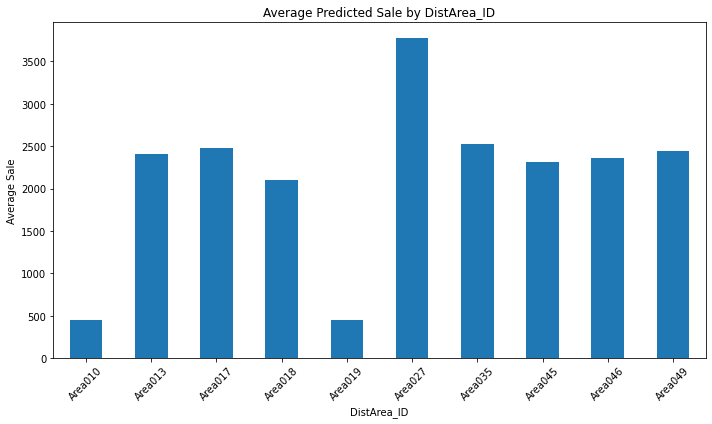

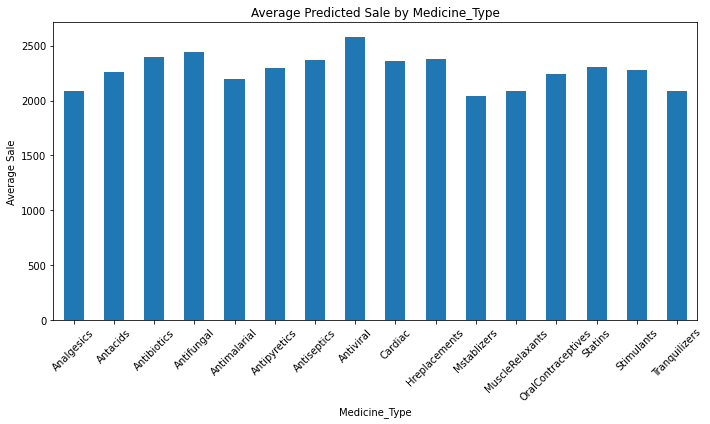

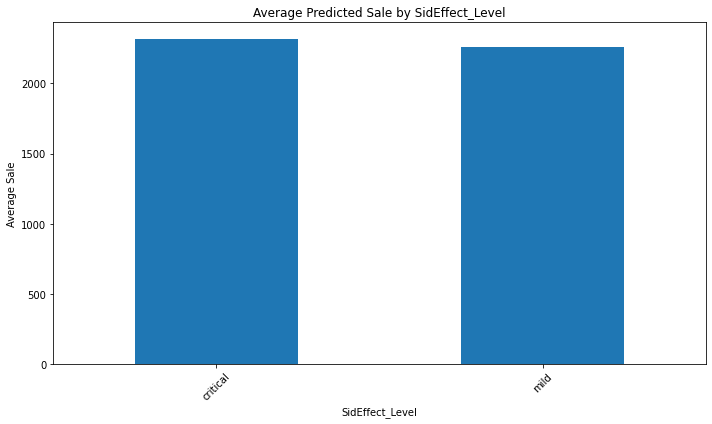

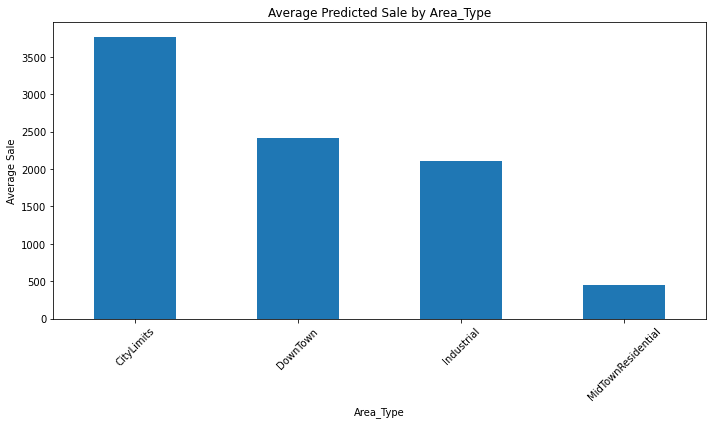

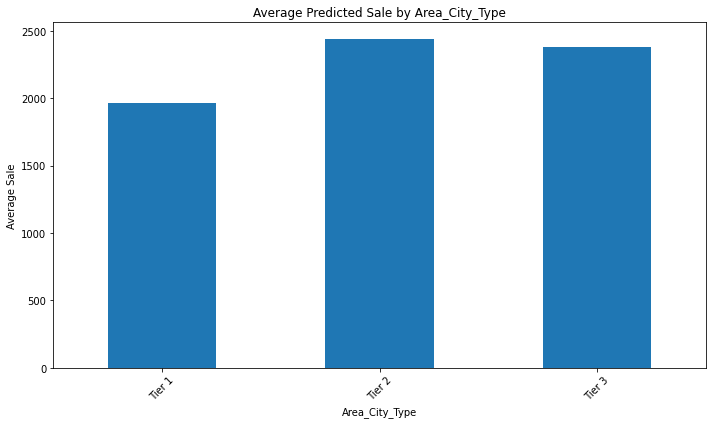

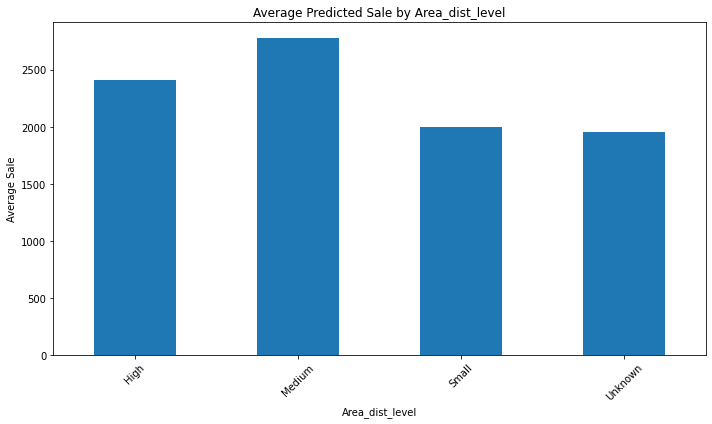

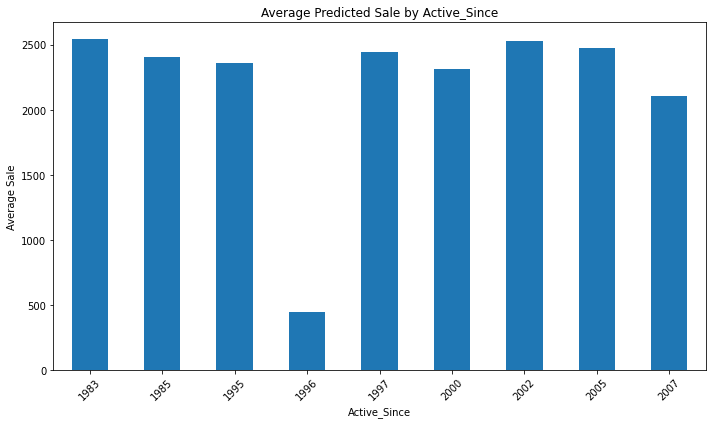

In [38]:
for i in categorical_column:
    category_sales = train_data.groupby(i)['Counterfeit_Sales'].mean()
    plt.figure(figsize=(10,6))
    category_sales.plot(kind='bar')
    plt.title(f'Average Predicted Sale by {i}')
    plt.xlabel(f'{i}')
    plt.ylabel('Average Sale')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()   

In [39]:
cross_tab = pd.crosstab(train_data['Area_Type'], train_data['Area_City_Type'])

In [40]:
print(cross_tab)

Area_City_Type      Tier 1  Tier 2  Tier 3
Area_Type                                 
CityLimits               0       0     735
DownTown              1488    2244     749
Industrial               0       0     729
MidTownResidential     431       0     442


In [41]:
# import pandas as pd
from scipy.stats import chi2_contingency

# # Create a sample DataFrame with multiple categorical columns
# data = {'Category1': ['A', 'B', 'A', 'C', 'B', 'A', 'A', 'C', 'B', 'C'],
#         'Category2': ['X', 'Y', 'Y', 'X', 'X', 'Y', 'X', 'Y', 'X', 'Y'],
#         'Category3': ['Low', 'Low', 'High', 'Medium', 'Medium', 'Low', 'High', 'Medium', 'High', 'Low']}
# df = pd.DataFrame(data)

# Perform chi-square test for each pair of categorical variables
for col1 in categorical_column:
    for col2 in categorical_column:
        if col1=='Medicine_ID' or col2=='Medicine_ID':
            continue
        if col1 != col2:
            contingency_table = pd.crosstab(train_data[col1], train_data[col2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            # print(f"Chi-square test between {col1} and {col2}:")
            # print(f"  Chi-square value: {chi2}")
            # print(f"  p-value: {p_value}")
            if p_value < 0.05:  # Significance level of 0.05
                print("  Significant association!")
                print(f"Chi-square test between {col1} and {col2}:")
                print(f"  Chi-square value: {chi2}")
                print(f"  p-value: {p_value}")
            # else:
            #     print("  No significant association.")
            print()




  Significant association!
Chi-square test between DistArea_ID and Area_Type:
  Chi-square value: 20454.0
  p-value: 0.0

  Significant association!
Chi-square test between DistArea_ID and Area_City_Type:
  Chi-square value: 13636.0
  p-value: 0.0

  Significant association!
Chi-square test between DistArea_ID and Area_dist_level:
  Chi-square value: 20454.0
  p-value: 0.0

  Significant association!
Chi-square test between DistArea_ID and Active_Since:
  Chi-square value: 54544.0
  p-value: 0.0


  Significant association!
Chi-square test between Medicine_Type and SidEffect_Level:
  Chi-square value: 1184.4523321799566
  p-value: 3.5749117734420724e-243






  Significant association!
Chi-square test between SidEffect_Level and Medicine_Type:
  Chi-square value: 1184.4523321799566
  p-value: 3.5749117734420724e-243





  Significant association!
Chi-square test between Area_Type and DistArea_ID:
  Chi-square value: 20454.0
  p-value: 0.0



  Significant association!
Chi-square te

In [58]:
area_cols=['DistArea_ID','Area_Type','Area_City_Type','Area_dist_level']

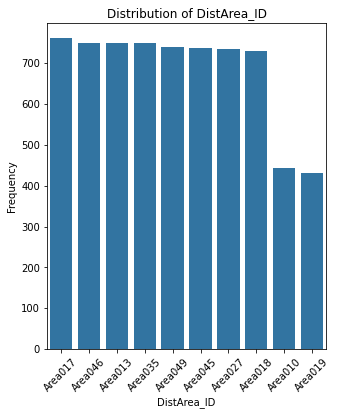

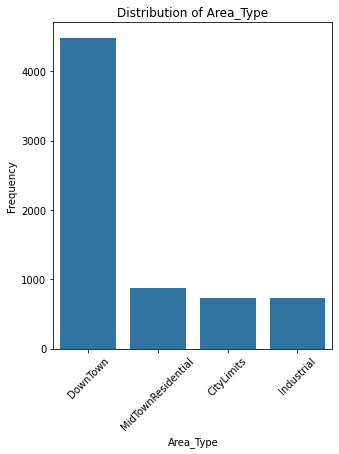

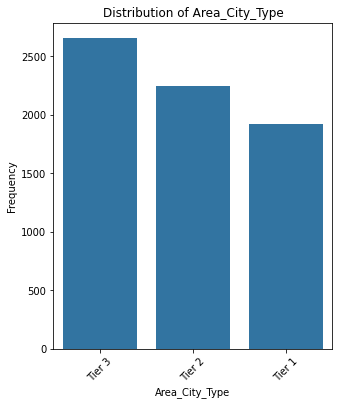

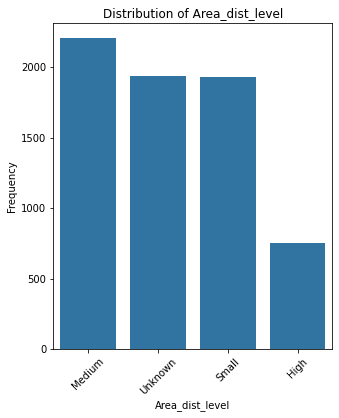

In [59]:
for col in area_cols:
    area_counts = train_data[col].value_counts()
    plt.figure(figsize=(5, 6))
    sns.countplot(x=f'{col}', data=train_data, order=train_data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

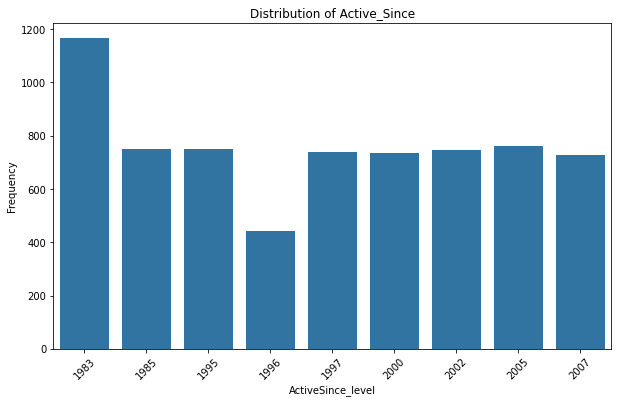

In [84]:
# Frequency distribution
ActiveSince_counts = train_data['Medicine_Type'].value_counts()

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='Active_Since', data=train_data)
plt.title('Distribution of Active_Since')
plt.xlabel('ActiveSince_level')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [53]:
cross_tab = pd.crosstab(train_data['DistArea_ID'], train_data['Area_Type'])
print(cross_tab)

Area_Type    CityLimits  DownTown  Industrial  MidTownResidential
DistArea_ID                                                      
Area010               0         0           0                 442
Area013               0       749           0                   0
Area017               0       760           0                   0
Area018               0         0         729                   0
Area019               0         0           0                 431
Area027             735         0           0                   0
Area035               0       748           0                   0
Area045               0       736           0                   0
Area046               0       749           0                   0
Area049               0       739           0                   0


In [62]:
cross_tab = pd.crosstab(train_data['Area_Type'], train_data['Area_dist_level'])
print(cross_tab)

Area_dist_level     High  Medium  Small  Unknown
Area_Type                                       
CityLimits             0     735      0        0
DownTown             749     739   1497     1496
Industrial             0     729      0        0
MidTownResidential     0       0    431      442


In [63]:
cross_tab = pd.crosstab(train_data['Area_Type'], train_data['Area_City_Type'])
print(cross_tab)

Area_City_Type      Tier 1  Tier 2  Tier 3
Area_Type                                 
CityLimits               0       0     735
DownTown              1488    2244     749
Industrial               0       0     729
MidTownResidential     431       0     442


In [68]:
category_sales = train_data.groupby(['DistArea_ID','Area_Type','Area_City_Type','Area_dist_level'])['Counterfeit_Sales'].mean()

In [70]:
category_sales

DistArea_ID  Area_Type           Area_City_Type  Area_dist_level
Area010      MidTownResidential  Tier 3          Unknown             445.985861
Area013      DownTown            Tier 3          High               2407.024123
Area017      DownTown            Tier 2          Unknown            2476.010053
Area018      Industrial          Tier 3          Medium             2106.573248
Area019      MidTownResidential  Tier 1          Small               449.755770
Area027      CityLimits          Tier 3          Medium             3772.254917
Area035      DownTown            Tier 2          Small              2529.951912
Area045      DownTown            Tier 2          Unknown            2310.996675
Area046      DownTown            Tier 1          Small              2358.722955
Area049      DownTown            Tier 1          Medium             2442.677445
Name: Counterfeit_Sales, dtype: float64

Insights from categorical feature - 'Medicine_Type','SidEffect_Level','Area_City_Type','Area_dist_level' - One hot Encoding
                                    'Area_Type' - Label Encoding

In [74]:
category_count = train_data.groupby(['DistArea_ID','Area_Type','Area_City_Type','Area_dist_level'])['Counterfeit_Weight'].mean()
category_count

DistArea_ID  Area_Type           Area_City_Type  Area_dist_level
Area010      MidTownResidential  Tier 3          Unknown            14.234570
Area013      DownTown            Tier 3          High               14.328952
Area017      DownTown            Tier 2          Unknown            14.017362
Area018      Industrial          Tier 3          Medium             14.140508
Area019      MidTownResidential  Tier 1          Small              13.800000
Area027      CityLimits          Tier 3          Medium             13.800000
Area035      DownTown            Tier 2          Small              14.047647
Area045      DownTown            Tier 2          Unknown            13.996583
Area046      DownTown            Tier 1          Small              14.099633
Area049      DownTown            Tier 1          Medium             14.104005
Name: Counterfeit_Weight, dtype: float64

In [14]:
# Label encoding over Area_Type
custom_mapping = {'CityLimits':4,'DownTown':3,'Industrial':2,'MidTownResidential':1}
train_data['Area_Type'] = train_data['Area_Type'].map(custom_mapping)

In [15]:
for i in categorical_column:
    if i != 'Area_Type':
        freqs = train_data[i].value_counts()
        k = freqs.index[freqs>20][:-1]

        for cat in k:
            name = f'{i}_{cat}'
            train_data[name] = (train_data[i]==cat).astype(int)
        
        del train_data[i]
        print(i)

# freqs = train_data['Medicine_Type'].value_counts()
# k = freqs.index[freqs>20][:-1]

DistArea_ID
Medicine_Type
SidEffect_Level
Area_City_Type
Area_dist_level
Active_Since


In [16]:
train_data.head()

,Medicine_ID,Counterfeit_Weight,Medicine_MRP,Availability_rating,Area_Type,Counterfeit_Sales,DistArea_ID_Area017,DistArea_ID_Area046,DistArea_ID_Area013,DistArea_ID_Area035,...,Area_dist_level_Unknown,Area_dist_level_Small,Active_Since_1983,Active_Since_2005,Active_Since_1995,Active_Since_1985,Active_Since_2002,Active_Since_1997,Active_Since_2000,Active_Since_2007
0,RRA15,13.100,160.2366,0.070422,3,1775.5026,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
1,YVV26,NaN,110.4384,0.013000,4,3069.1520,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,LJC15,9.025,259.4092,0.060783,3,2603.0920,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
3,GWC40,11.800,99.9830,0.065555,3,1101.7130,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,QMN13,NaN,56.4402,0.248859,1,158.9402,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [17]:
numerical_columns = ['Counterfeit_Weight','Medicine_MRP','Availability_rating']

In [73]:
# imputing missing values with median in numrical col.
for col in numerical_columns:
    med = train_data[col].median()
    train_data[col] = train_data[col].fillna(med)

In [19]:
for i in train_data.columns:
    if train_data[i].dtype=='object':
        print(i)

Medicine_ID


In [20]:
train_data = train_data.drop(columns=['Medicine_ID'])

In [21]:
train_data.head()

,Counterfeit_Weight,Medicine_MRP,Availability_rating,Area_Type,Counterfeit_Sales,DistArea_ID_Area017,DistArea_ID_Area046,DistArea_ID_Area013,DistArea_ID_Area035,DistArea_ID_Area049,...,Area_dist_level_Unknown,Area_dist_level_Small,Active_Since_1983,Active_Since_2005,Active_Since_1995,Active_Since_1985,Active_Since_2002,Active_Since_1997,Active_Since_2000,Active_Since_2007
0,13.100,160.2366,0.070422,3,1775.5026,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,13.800,110.4384,0.013000,4,3069.1520,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,9.025,259.4092,0.060783,3,2603.0920,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,11.800,99.9830,0.065555,3,1101.7130,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,13.800,56.4402,0.248859,1,158.9402,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [78]:
filtered_df = train_data[train_data['DistArea_ID'] == 'Area019']
filtered_df

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
4,QMN13,13.8,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402
12,RUT58,13.8,Area019,1983,118.5280,MuscleRelaxants,mild,0.036403,MidTownResidential,Tier 1,Small,326.0560
43,LFG35,13.8,Area019,1983,59.2034,Mstablizers,mild,0.078652,MidTownResidential,Tier 1,Small,161.6034
57,EBS47,13.8,Area019,1983,69.8220,Mstablizers,critical,0.225963,MidTownResidential,Tier 1,Small,412.6100
71,NDK33,13.8,Area019,1983,150.6180,Antimalarial,mild,0.042299,MidTownResidential,Tier 1,Small,252.8180
...,...,...,...,...,...,...,...,...,...,...,...,...
6780,SWF56,13.8,Area019,1983,108.5042,Antimalarial,mild,0.185310,MidTownResidential,Tier 1,Small,311.4084
6785,ZTV97,13.8,Area019,1983,85.0696,OralContraceptives,mild,0.076650,MidTownResidential,Tier 1,Small,187.5696
6794,ZQT22,13.8,Area019,1983,51.8796,OralContraceptives,mild,0.161393,MidTownResidential,Tier 1,Small,154.2796
6798,JPE14,13.8,Area019,1983,195.4898,OralContraceptives,mild,0.023615,MidTownResidential,Tier 1,Small,487.1796


In [20]:
train_data.head()

,Counterfeit_Weight,Medicine_MRP,Availability_rating,Counterfeit_Sales,Medicine_Type_Hreplacements,Medicine_Type_Antibiotics,Medicine_Type_Antiseptics,Medicine_Type_OralContraceptives,Medicine_Type_Antipyretics,Medicine_Type_Cardiac,...,Area_rep_Area017_Tier 2_DownTown_Unknown,Area_rep_Area046_Tier 1_DownTown_Small,Area_rep_Area013_Tier 3_DownTown_High,Area_rep_Area035_Tier 2_DownTown_Small,Area_rep_Area049_Tier 1_DownTown_Medium,Area_rep_Area045_Tier 2_DownTown_Unknown,Area_rep_Area027_Tier 3_CityLimits_Medium,Area_rep_Area018_Tier 3_Industrial_Medium,Area_rep_Area010_Tier 3_MidTownResidential_Unknown,SidEffect_Level_mild
0,13.100,160.2366,0.070422,1775.5026,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,13.800,110.4384,0.013000,3069.1520,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,9.025,259.4092,0.060783,2603.0920,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,11.800,99.9830,0.065555,1101.7130,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,13.800,56.4402,0.248859,158.9402,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Correlation Matrix:
                    Counterfeit_Weight  Counterfeit_Sales
Counterfeit_Weight             1.00000            0.00814
Counterfeit_Sales              0.00814            1.00000


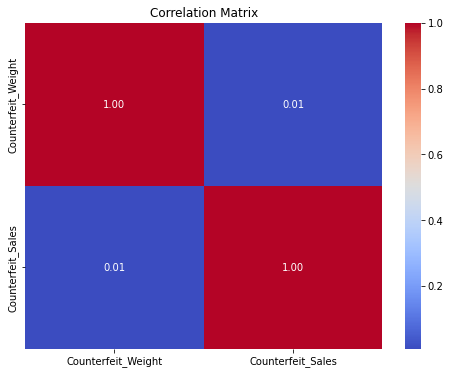

In [39]:
# Calculate correlation matrix
correlation_matrix = train_data[['Counterfeit_Weight', 'Counterfeit_Sales']].corr(method='spearman')

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


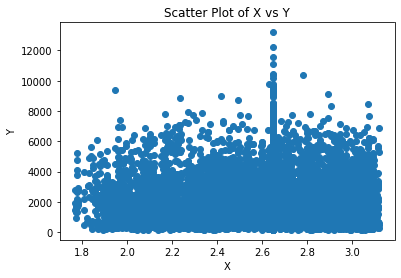

In [63]:

# To check for non-linear relationships between two variables, you can use various techniques, including visual inspection, polynomial regression, and correlation tests. Here are some methods you can use:

# 1. Scatter Plot:
# Visualize the relationship between the variables using a scatter plot. Look for patterns that do not follow a straight line.

# python
# Copy code
# import matplotlib.pyplot as plt

plt.scatter(train_data['Counterfeit_Weight'],train_data['Counterfeit_Sales'])
plt.title('Scatter Plot of X vs Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [64]:
from scipy.stats import spearmanr

# Compute Spearman correlation coefficient
spearman_corr, p_value = spearmanr(train_data['Counterfeit_Weight'],train_data['Counterfeit_Sales'])
print("Spearman correlation coefficient:", spearman_corr)
print("p-value:", p_value)

Spearman correlation coefficient: 0.008139613582196501
p-value: 0.5015929853806975


In [ ]:
np.log(train_data['Cou'])